In [3]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings("ignore")
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc, average_precision_score, precision_recall_curve, plot_precision_recall_curve, f1_score
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy import stats
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('Reviews.csv', index_col=0)
df = df.dropna()

In [5]:
df.shape

(568411, 9)

In [6]:
df.head(6)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


Text(0, 0.5, 'Counts')

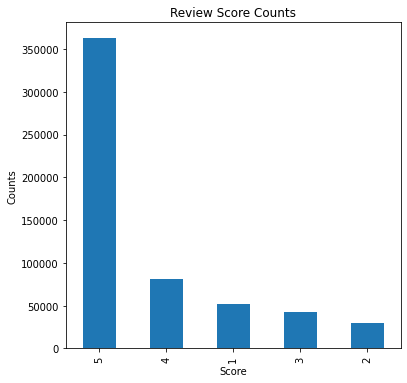

In [7]:
ax = df['Score'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Review Score Counts")
ax.set_xlabel('Score')
ax.set_ylabel('Counts')

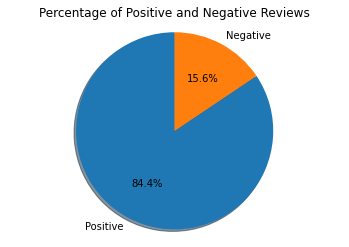

In [8]:
labels = 'Positive', 'Negative'
sizes = [len(np.where(df['Score']>3)[0]), len(np.where(df['Score']<3)[0])]
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Percentage of Positive and Negative Reviews')
plt.show()

In [9]:
data =df.sample(n=10000, random_state=920)
data.shape

(10000, 9)

Text(0, 0.5, 'Counts')

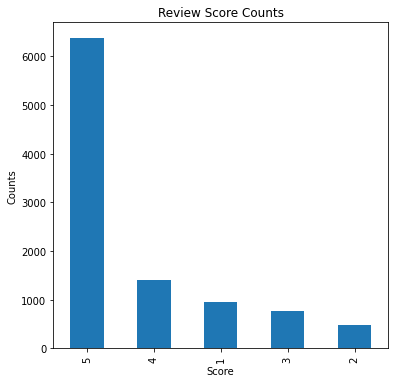

In [10]:
ax = data['Score'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Review Score Counts")
ax.set_xlabel('Score')
ax.set_ylabel('Counts')

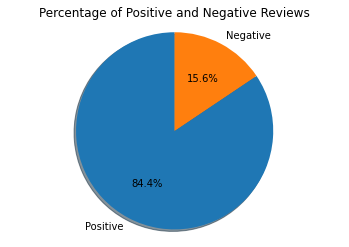

In [11]:
labels = 'Positive', 'Negative'
sizes = [len(np.where(data['Score']>3)[0]), len(np.where(data['Score']<3)[0])]
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Percentage of Positive and Negative Reviews')
plt.show()

In [12]:
data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, inplace=True)
data.shape

(9850, 9)

In [13]:
data.drop(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Time'], axis = 1, inplace=True)

In [14]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
stopwords = set(stopwords.words('english'))
stopwords.update(["br","href"])

In [16]:
txt = []    
for sent in tqdm(data['Text'].values):  
    sent = re.sub(r"http\S+", "", sent)
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = re.sub("\S*\d\S*", "", sent).strip()
    sent = re.sub('[^A-Za-z]+', ' ', sent)
    sent = " ".join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    txt.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9850/9850 [00:06<00:00, 1447.08it/s]


In [17]:
sum = []    
for sent in tqdm(data['Summary'].values):  
    sent = re.sub(r"http\S+", "", sent)
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = decontracted(sent)
    sent = re.sub("\S*\d\S*", "", sent).strip()
    sent = re.sub('[^A-Za-z]+', ' ', sent)
    sent = " ".join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    sum.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9850/9850 [00:04<00:00, 2003.24it/s]


In [18]:
data['Text'] = txt
data['Summary'] = sum

In [19]:
data = data.reset_index(inplace=False)

In [20]:
data.drop(['Id'], axis=1, inplace=True)
data.head() 

,Score,Summary,Text
0,5,best chips ever,stumbled multigrain chips little store work lo...
1,4,pretty good gluten free dairy free option,surprised find gf dairy free bar starbucks tra...
2,5,good healthy breakfast snack,love fair amount protein sugar source directly...
3,5,best litter ever smell,using litter years one cat one bag lasts entir...
4,5,love,far favorite pretzels ever taste mild like pre...


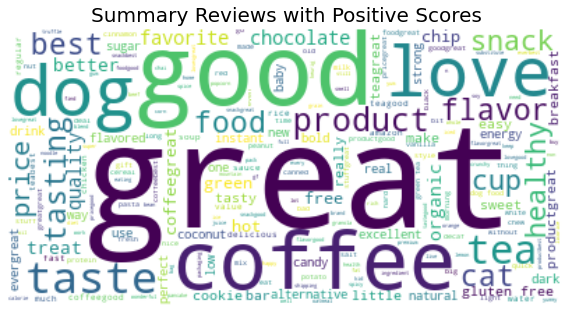

In [21]:
txt = data.Summary[np.where(data['Score']>3)[0]].str.cat()
wordcloud = WordCloud(background_color='white').generate(txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Reviews with Positive Scores',fontsize=20)
plt.show()

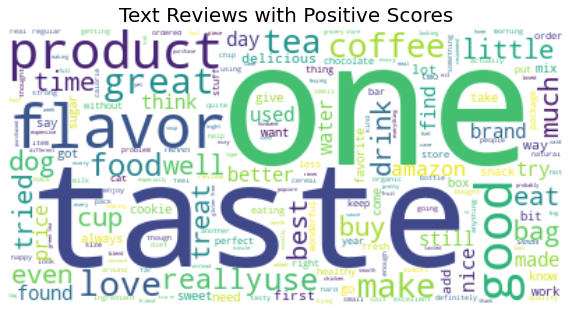

In [22]:
txt = data.Text[np.where(data['Score']>3)[0]].str.cat()
wordcloud = WordCloud(background_color='white').generate(txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Text Reviews with Positive Scores',fontsize=20)
plt.show()

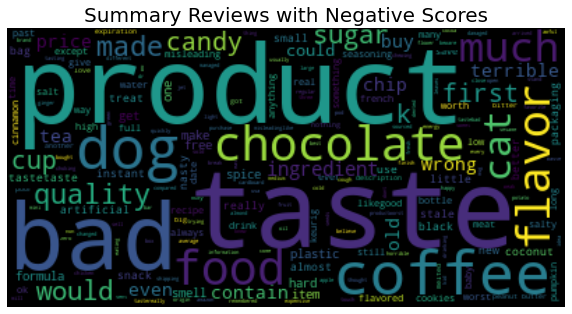

In [23]:
txt = data.Summary[np.where(data['Score']<3)[0]].str.cat()
stopwords.update(["good","great","like"]) 
wordcloud = WordCloud(stopwords=stopwords).generate(txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Summary Reviews with Negative Scores',fontsize=20)
plt.axis("off")
plt.show()

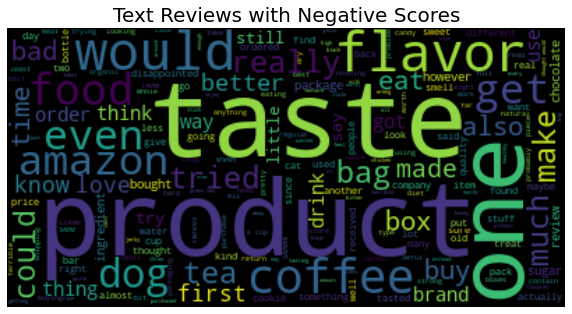

In [24]:
txt = data.Text[np.where(data['Score']<3)[0]].str.cat()
wordcloud = WordCloud(stopwords=stopwords).generate(txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Text Reviews with Negative Scores',fontsize=20)
plt.axis("off")
plt.show()

In [25]:
plt.style.use('fivethirtyeight')
cp = sns.color_palette()
analyzer = SentimentIntensityAnalyzer()
sent=[]
for row in data['Text']:
    vs=analyzer.polarity_scores(row)
    sent.append(vs)
sent=pd.DataFrame(sent)
sent.head()

,neg,neu,pos,compound
0,0.000,0.575,0.425,0.9191
1,0.000,0.514,0.486,0.9670
2,0.000,0.627,0.373,0.9382
3,0.000,0.822,0.178,0.6369
4,0.077,0.607,0.316,0.9153


In [26]:
data = pd.concat([data.reset_index(drop=True), sent['compound']], axis=1)
data['Sentiment'] = np.where(data['compound'] >= 0 , 1, 0)

In [27]:
data.Sentiment[np.where(data['Score']<3)[0]]=0

In [28]:
len(np.where(data['Sentiment']==0)[0])

1700

In [29]:
len(np.where(data['Score']<3)[0])

1413

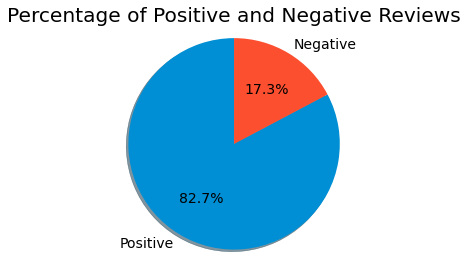

In [30]:
labels = 'Positive', 'Negative'
sizes = [len(np.where(data['Sentiment']==1)[0]), len(np.where(data['Sentiment']==0)[0])]
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Percentage of Positive and Negative Reviews')
plt.show()

In [31]:
data.head()

,Score,Summary,Text,compound,Sentiment
0,5,best chips ever,stumbled multigrain chips little store work lo...,0.9191,1
1,4,pretty good gluten free dairy free option,surprised find gf dairy free bar starbucks tra...,0.9670,1
2,5,good healthy breakfast snack,love fair amount protein sugar source directly...,0.9382,1
3,5,best litter ever smell,using litter years one cat one bag lasts entir...,0.6369,1
4,5,love,far favorite pretzels ever taste mild like pre...,0.9153,1


In [32]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x = bow_converter.fit_transform(data['Text'])
words = bow_converter.get_feature_names()
len(words)

27

In [33]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(data['Text'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

645

In [57]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(data['Text'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

6984

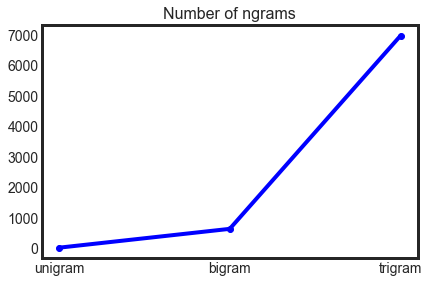

In [61]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams', {'fontsize':16})
plt.show()

In [34]:
df_bow = pd.DataFrame(x.todense())
df_bow.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,23,7,3,5,5,15,1,4,2,9,...,0,7,7,10,5,3,4,2,1,1
1,31,16,3,5,10,21,5,8,7,9,...,0,13,12,14,4,2,2,0,3,1
2,30,14,1,5,7,20,5,8,2,15,...,0,16,13,11,6,5,1,0,2,0
3,25,10,4,4,5,17,2,3,2,9,...,0,8,9,16,2,1,0,1,3,0
4,36,18,1,8,3,25,3,3,11,16,...,0,15,14,22,5,4,2,1,8,3


In [35]:
tfidf = text.TfidfTransformer(norm=None)
X_tfidf = tfidf.fit_transform(x)
df_tfidf = pd.DataFrame(X_tfidf.todense())
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,23.060785,7.040621,3.429139,5.111891,5.122803,15.045750,1.124825,4.148916,2.157499,9.084447,...,0.0,7.042051,7.041336,10.054968,5.212026,3.489116,4.803134,3.853193,1.089016,2.222173
1,31.081927,16.092848,3.429139,5.111891,10.245607,21.064050,5.624124,8.297832,7.551245,9.084447,...,0.0,13.078094,12.070862,14.076955,4.169621,2.326077,2.401567,0.000000,3.267048,2.222173
2,30.079284,14.081242,1.143046,5.111891,7.171925,20.061000,5.624124,8.297832,2.157499,15.140746,...,0.0,16.096116,13.076767,11.060464,6.254431,5.815193,1.200783,0.000000,2.178032,0.000000
3,25.066070,10.058030,4.572185,4.089513,5.122803,17.051850,2.249650,3.111687,2.157499,9.084447,...,0.0,8.048058,9.053146,16.087948,2.084810,1.163039,0.000000,1.926596,3.267048,0.000000
4,36.095141,18.104454,1.143046,8.179026,3.073682,25.076251,3.374474,3.111687,11.866242,16.150129,...,0.0,15.090109,14.082672,22.120929,5.212026,4.652154,2.401567,1.926596,8.712128,6.666518


In [36]:
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(df_bow, data['Sentiment'],test_size=0.3,random_state=9)

In [37]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df_tfidf, data['Sentiment'],test_size=0.3,random_state=20)

In [195]:
def logistic_cv(X_train, X_test, y_train, y_test):
    param_grid_logistic={'C':[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}
    logistic_cv=GridSearchCV(LogisticRegression(penalty = 'l2'), param_grid_logistic, cv=5)
    logistic_cv.fit(X_train,y_train)
    model = sm.Logit(y_train, X_train)
    mod = model.fit()
    print(mod.summary())
    print(logistic_cv.best_params_)
    logistic_test=logistic_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, logistic_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",round(f1_score(y_test,logistic_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,logistic_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,round(roc_auc_score(y_test,logistic_test),5))
    test_confusion_matrix=confusion_matrix(y_test, logistic_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])
    disp = plot_precision_recall_curve(logistic_cv, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                       'AP={0:0.2f}'.format(auc_precision_recall))

Optimization terminated successfully.
         Current function value: 0.523473
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Sentiment   No. Observations:                 6895
Model:                          Logit   Df Residuals:                     6868
Method:                           MLE   Df Model:                           26
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                 -0.1248
Time:                        01:05:29   Log-Likelihood:                -3609.3
converged:                       True   LL-Null:                       -3208.8
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0001      0.013      0.010      0.992      -0.025       0.025
1              0.0039      0.

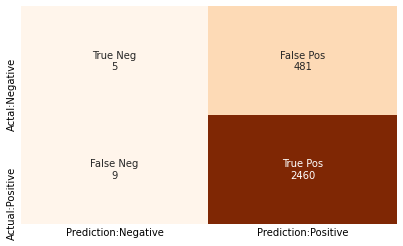

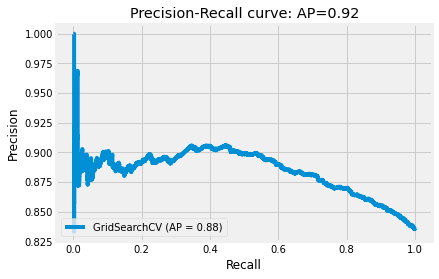

In [196]:
logistic_cv(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

Optimization terminated successfully.
         Current function value: 0.519601
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Sentiment   No. Observations:                 6895
Model:                          Logit   Df Residuals:                     6868
Method:                           MLE   Df Model:                           26
Date:                Mon, 21 Dec 2020   Pseudo R-squ.:                 -0.1274
Time:                        01:05:33   Log-Likelihood:                -3582.6
converged:                       True   LL-Null:                       -3177.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0018      0.013      0.138      0.890      -0.023       0.027
1              0.0049      0.

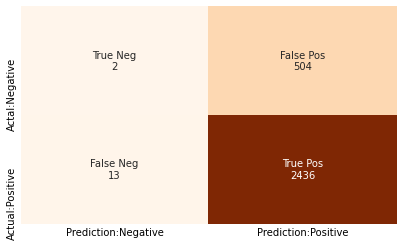

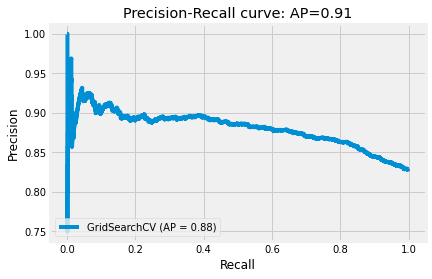

In [197]:
logistic_cv(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

In [93]:
def svm_cv(X_train, X_test, y_train, y_test):
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    param_grid_svm={'C':[10**(i+1) for i in range(-2,2)], 'gamma':[10**(i+1) for i in range(-3,2)],'kernel':['rbf','sigmoid']}
    svm_cv=GridSearchCV(SVC(random_state=1206), param_grid_svm, cv=5)
    svm_cv.fit(X_train,y_train)
    print(svm_cv.best_params_)
    svm_test=svm_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, svm_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / AUC-PR  \n",round(f1_score(y_test,svm_test, average="micro"),2),'           /' ,
          round(f1_score(y_test,svm_test, average="macro"),2),'           /' ,
          round(auc_precision_recall,2))
    test_confusion_matrix=confusion_matrix(y_test, svm_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])
    disp = plot_precision_recall_curve(svm_cv, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                       'AP={0:0.2f}'.format(auc_precision_recall))

In [202]:
def svm_cv2(X_train, X_test, y_train, y_test):
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    param_grid_svm={'C':[0.1], 'gamma':[0.01],'kernel':['rbf']}
    svm_cv=GridSearchCV(SVC(random_state=1206), param_grid_svm, cv=5)
    svm_cv.fit(X_train,y_train)
    print(svm_cv.best_params_)
    svm_test=svm_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, svm_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",round(f1_score(y_test,svm_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,svm_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,round(roc_auc_score(y_test,svm_test),5))
svm_cv2(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.83553          / 0.4552   / 0.91777     / 0.5


In [203]:
svm_cv2(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.82876          / 0.45318   / 0.91438     / 0.5


{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.84            / 0.46            / 0.92
Test confusion matrix


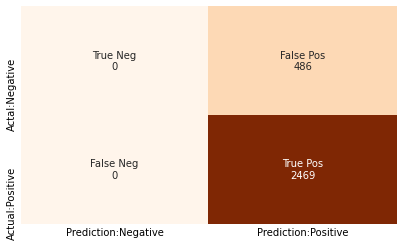

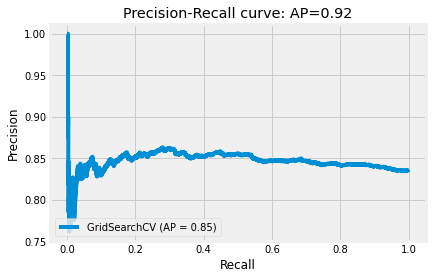

In [94]:
svm_cv(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.83            / 0.45            / 0.91
Test confusion matrix


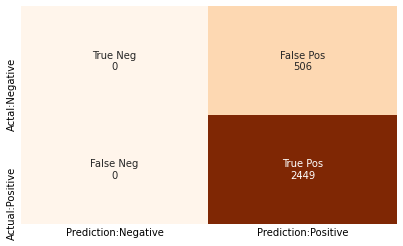

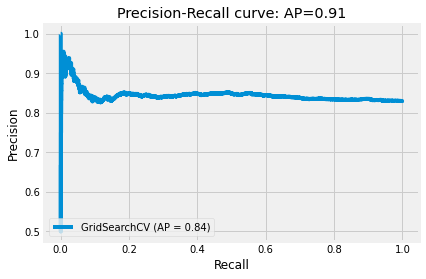

In [95]:
svm_cv(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

In [138]:
def cart_cv(X_train, X_test, y_train, y_test):
#     pca = PCA(n_components=10)
#     X_train = pca.fit_transform(X_train)
#     X_test = pca.transform(X_test)
    param_grid_cart={'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12]}
    cart_cv=GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid_cart, cv=5)
    cart_cv.fit(X_train,y_train)
    print(cart_cv.best_params_)
    cart_test=cart_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, cart_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / AUC-PR  \n",round(f1_score(y_test,cart_test, average="micro"),5),'           /' ,
          round(f1_score(y_test,cart_test, average="macro"),5),'           /' ,
          round(auc_precision_recall,5))
    test_confusion_matrix=confusion_matrix(y_test, cart_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])
    disp = plot_precision_recall_curve(cart_cv, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                       'AP={0:0.2f}'.format(auc_precision_recall))

In [204]:
def cart_cv2(X_train, X_test, y_train, y_test):
    param_grid_cart={'criterion': ['gini', 'entropy'], 'max_depth': [2]}
    cart_cv=GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid_cart, cv=5)
    cart_cv.fit(X_train,y_train)
    print(cart_cv.best_params_)
    cart_test=cart_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, cart_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",round(f1_score(y_test,cart_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,cart_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,round(roc_auc_score(y_test,cart_test),5))
cart_cv2(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'criterion': 'entropy', 'max_depth': 2}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.83553          / 0.4552   / 0.91777     / 0.5


In [206]:
cart_cv2(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

{'criterion': 'gini', 'max_depth': 2}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.82876          / 0.45318   / 0.91438     / 0.5


{'criterion': 'entropy', 'max_depth': 2}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.83553            / 0.4552            / 0.91777
Test confusion matrix


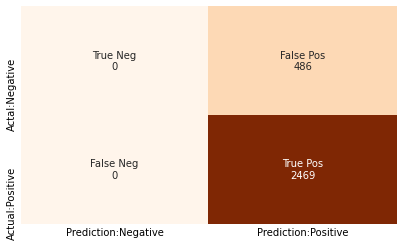

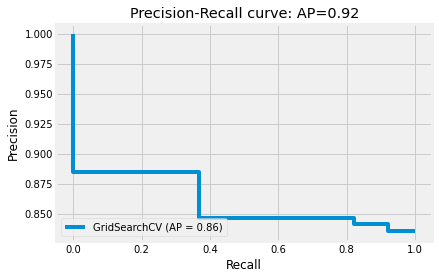

In [139]:
cart_cv(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'criterion': 'gini', 'max_depth': 2}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.82876            / 0.45318            / 0.91438
Test confusion matrix


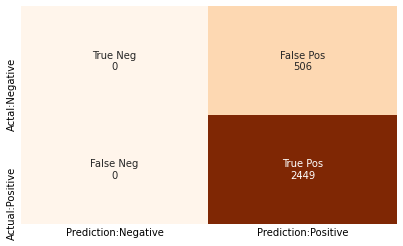

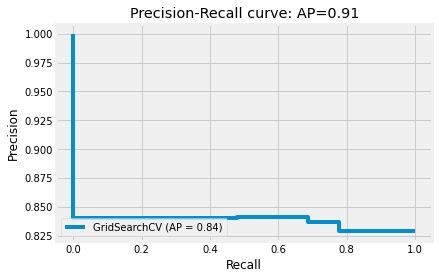

In [140]:
cart_cv(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

In [141]:
def rf_cv(X_train, X_test, y_train, y_test):
#     pca = PCA(n_components=10)
#     X_train = pca.fit_transform(X_train)
#     X_test = pca.transform(X_test)
    param_grid_rf={'criterion':["gini","entropy"] ,'max_features':['sqrt','log2',X_train.shape[1]]}
    rf_cv=GridSearchCV(RandomForestClassifier(random_state=100), param_grid_rf, cv=5)
    rf_cv.fit(X_train,y_train)
    print(rf_cv.best_params_)
    rf_test=rf_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, rf_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / AUC-PR  \n",round(f1_score(y_test,rf_test, average="micro"),5),'           /' ,
          round(f1_score(y_test,rf_test, average="macro"),5),'           /' ,
          round(auc_precision_recall,5))
    test_confusion_matrix=confusion_matrix(y_test, rf_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])
    disp = plot_precision_recall_curve(rf_cv, X_test, y_test)
    disp.ax_.set_title('Precision-Recall curve: '
                       'AP={0:0.2f}'.format(auc_precision_recall))

In [41]:
def rf_cv2(X_train, X_test, y_train, y_test):
#     pca = PCA(n_components=10)
#     X_train = pca.fit_transform(X_train)
#     X_test = pca.transform(X_test)
    param_grid_rf={'criterion':["entropy"] ,'max_features':['log2']}
    rf_cv=GridSearchCV(RandomForestClassifier(random_state=100), param_grid_rf, cv=5)
    rf_cv.fit(X_train,y_train)
    print(rf_cv.best_params_)
    rf_test=rf_cv.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, rf_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n","F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",round(f1_score(y_test,rf_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,rf_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,round(roc_auc_score(y_test,rf_test),5))
rf_cv2(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'criterion': 'entropy', 'max_features': 'log2'}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.83486          / 0.455   / 0.91764     / 0.49959


In [40]:
rf_cv2(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

{'criterion': 'gini', 'max_features': 27}
Test:
 F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.82707          / 0.46219   / 0.91445     / 0.5029


{'criterion': 'entropy', 'max_features': 'log2'}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.83486            / 0.455            / 0.91764
Test confusion matrix


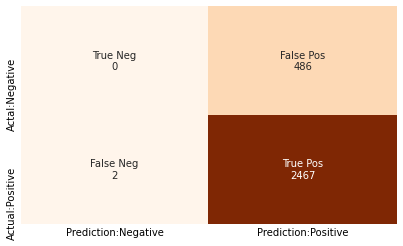

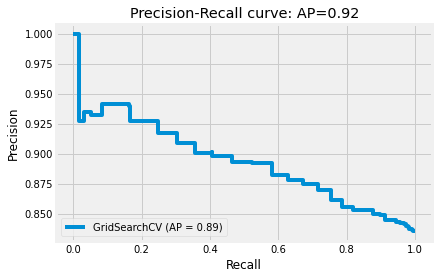

In [142]:
rf_cv(x_train_bow, x_test_bow, y_train_bow, y_test_bow)

{'criterion': 'gini', 'max_features': 27}
Test:
 F1 score(micro) / F1 score(macro) / AUC-PR  
 0.82707            / 0.46219            / 0.91445
Test confusion matrix


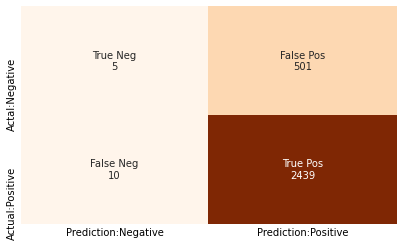

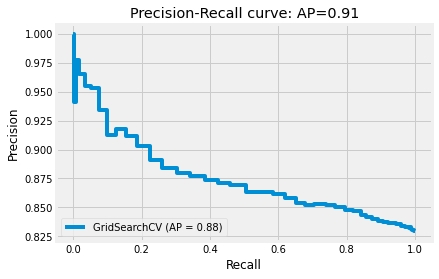

In [143]:
rf_cv(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf)

In [42]:
# model comparison 1 - bow
Algo = ['LogisticRegression(Bag-of-Words)','SVM(Bag-of-Words)','DecisionTree(Bag-of-Words)','RandomForest(Bag-of-Words)']
score11 = [0.83418 , 0.83381, 0.83553, 0.83519]
score22 = [0.46471 , 0.4578, 0.4552, 0.4553]
score33 = [0.91703, 0.91622, 0.91777, 0.91774]
score44 = [0.5033,  0.5023, 0.5012, 0.4995]
compare = pd.DataFrame({'Model':Algo,'F1_Score(micro)':score11, 'F1_Score(macro)':score22, 'AUC-PR':score33, 'ROC-AUC':score44})
compare.T

,0,1,2,3
Model,LogisticRegression(Bag-of-Words),SVM(Bag-of-Words),DecisionTree(Bag-of-Words),RandomForest(Bag-of-Words)
F1_Score(micro),0.83418,0.83381,0.83553,0.83519
F1_Score(macro),0.46471,0.4578,0.4552,0.4553
AUC-PR,0.91703,0.91622,0.91777,0.91774
ROC-AUC,0.5033,0.5023,0.5012,0.4995


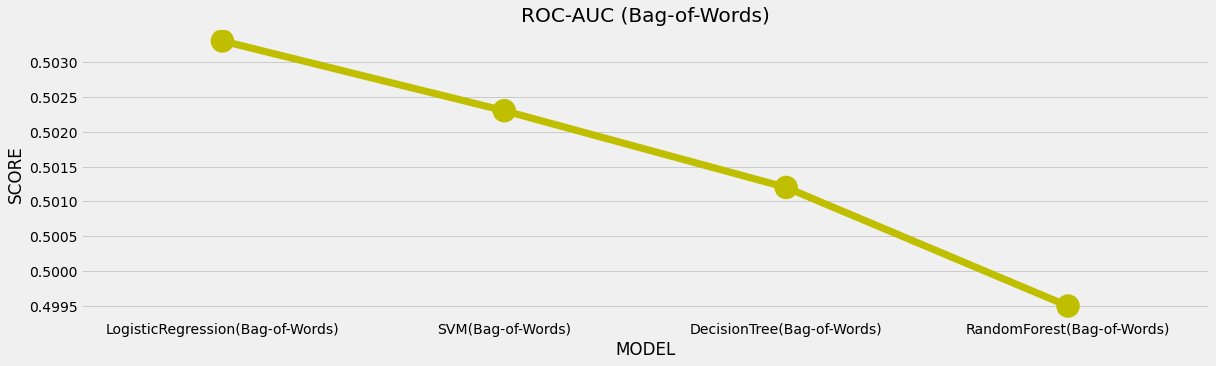

In [44]:
plt.figure(figsize=(18,5))
# plt1 = sns.pointplot(x='Model',y='F1_Score(micro)',data=compare, color="r")
# plt2 = sns.pointplot(x='Model',y='F1_Score(macro)',data=compare, color="g")
# plt3 = sns.pointplot(x='Model',y='AUC-PR',data=compare, color="b")
plt4 = sns.pointplot(x='Model',y='ROC-AUC',data=compare, color="y")
plt.title('ROC-AUC (Bag-of-Words)')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()

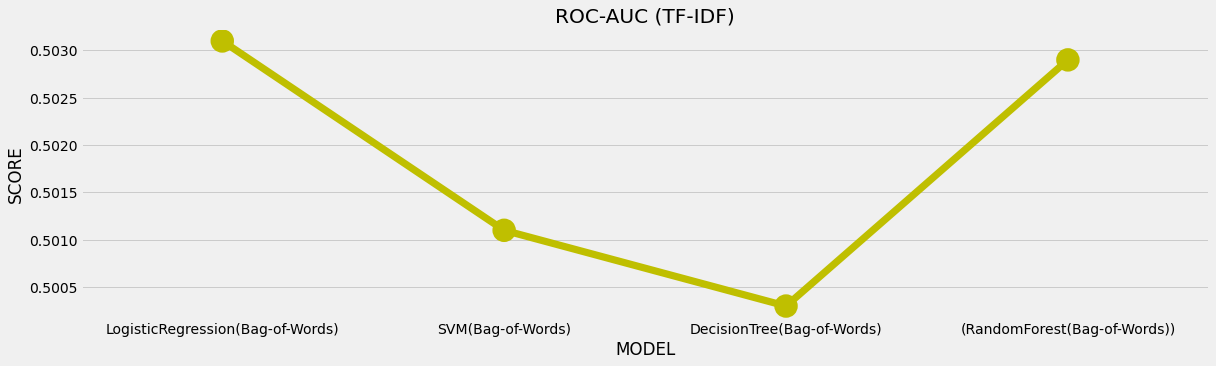

In [46]:
# model comparison 2 - tfidf
Algo = ['LogisticRegression(Bag-of-Words)','SVM(Bag-of-Words)','DecisionTree(Bag-of-Words)','(RandomForest(Bag-of-Words))']
score1 = [0.8250, 0.82466, 0.82707 , 0.82775]
score2 = [0.4558, 0.45412, 0.45318, 0.45674]
score3 = [0.91383, 0.91353, 0.91438, 0.91445]
score4 = [0.5031, 0.5011, 0.5003, 0.5029]
compare = pd.DataFrame({'Model':Algo,'F1_Score(micro)':score1, 'F1_Score(macro)':score2, 'AUC-PR':score3, 'ROC-AUC': score4})
plt.figure(figsize=(18,5))
# plt1 = sns.pointplot(x='Model',y='F1_Score(micro)',data=compare, color="r")
# plt2 = sns.pointplot(x='Model',y='F1_Score(macro)',data=compare, color="g")
# plt3 = sns.pointplot(x='Model',y='AUC-PR',data=compare, color="b")
plt4 = sns.pointplot(x='Model',y='ROC-AUC',data=compare, color="y")
plt.title('ROC-AUC (TF-IDF)')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()

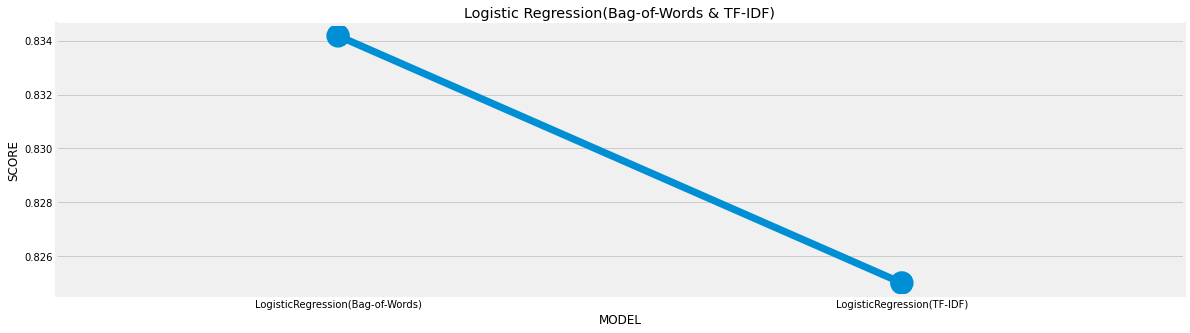

In [167]:
# model comparison 3 - best score
Algo_best = ['LogisticRegression(Bag-of-Words)','LogisticRegression(TF-IDF)']
score_best = [score11[0],score1[0]]
compare_best = pd.DataFrame({'Model':Algo_best,'F1_Score':score_best})
plt.figure(figsize=(18,5))
sns.pointplot(x='Model',y='F1_Score',data=compare_best)
plt.title('Logistic Regression(Bag-of-Words & TF-IDF)')
plt.xlabel('MODEL')
plt.ylabel('SCORE')
plt.show()

In [169]:
# compare between bow and tfidf
search_results = pd.DataFrame.from_dict({'bow': [0.83418 , 0.83381, 0.83553, 0.83519],
                               'tfidf': [0.8250, 0.82466, 0.82707 , 0.82775]})

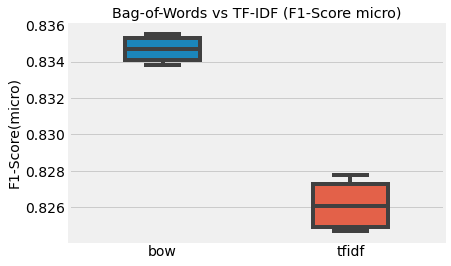

In [170]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('F1-Score(micro)', size=14)
ax.set_title('Bag-of-Words vs TF-IDF (F1-Score micro)')
ax.tick_params(labelsize=14)

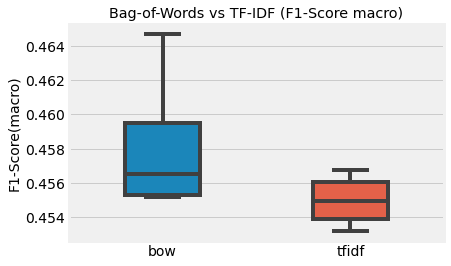

In [171]:
# compare between bow and tfidf
search_results = pd.DataFrame.from_dict({'bow': score22,
                               'tfidf': score2})
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('F1-Score(macro)', size=14)
ax.set_title('Bag-of-Words vs TF-IDF (F1-Score macro)')
ax.tick_params(labelsize=14)

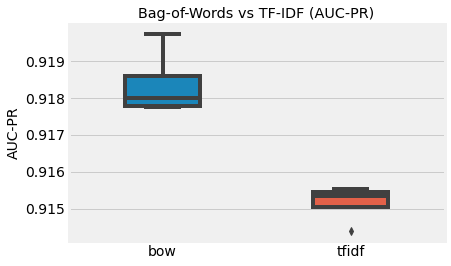

In [172]:
# compare between bow and tfidf
search_results = pd.DataFrame.from_dict({'bow': score33,
                               'tfidf': score3})
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_title('Bag-of-Words vs TF-IDF (AUC-PR)')
ax.set_ylabel('AUC-PR', size=14)
ax.tick_params(labelsize=14)

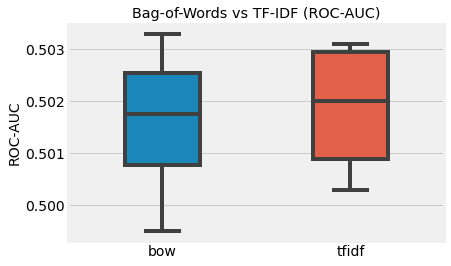

In [47]:
search_results = pd.DataFrame.from_dict({'bow': score44,
                               'tfidf': score4})
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_title('Bag-of-Words vs TF-IDF (ROC-AUC)')
ax.set_ylabel('ROC-AUC', size=14)
ax.tick_params(labelsize=14)